# EDA, Data Visualization, and Feature Engineering

In [1]:
# !bash push.sh

## IMPORTS

In [1]:
import requests
import pandas                        as pd
import numpy                         as np
import math
import imblearn
from imblearn.over_sampling import ADASYN

import seaborn                       as sns
import matplotlib.pyplot             as plt
from wordcloud                       import WordCloud, STOPWORDS 
import pyLDAvis
import pyLDAvis.gensim
from pprint                          import pprint

from googletrans                     import Translator
translator = Translator()
from spellchecker                    import SpellChecker
spellcheck = SpellChecker()

import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
from nltk.tokenize                   import TweetTokenizer
from nltk.corpus                     import stopwords
from nltk                            import bigrams

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cvec = CountVectorizer()
from sklearn.manifold                import TSNE
from sklearn.metrics                 import accuracy_score
from sklearn                         import preprocessing

import gensim
from gensim                          import models
from gensim.models                   import CoherenceModel
from gensim.models                   import Word2Vec
from gensim.models                   import Phrases
from gensim.models.phrases           import Phraser

import mittens
from mittens                         import GloVe

from collections                     import Counter
import itertools
import re
tokenizer = TweetTokenizer(preserve_case = True, strip_handles = True)

import random
import time
from tqdm                            import tqdm
import joblib
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/tqdm/auto/__init__.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.std.*` instead of `tqdm._tqdm.*`
  from .._tqdm import TqdmExperimentalWarning
/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from .._tqdm_notebook import tqdm_notebook as tqdm
/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
eng_train = pd.read_csv('Data/trac2_eng_train.csv')
eng_test = pd.read_csv('Data/trac2_eng_dev.csv')
eng = eng_train.append(eng_test, ignore_index=True)
eng.sample(5)

,ID,Text,Sub-task A,Sub-task B
3832,C7.2584,But love ur review,NAG,NGEN
4904,C10.332.1,Evangelicals who are no better than bounty lov...,NAG,NGEN
935,C68.279,yess broo,NAG,NGEN
1479,C7.98,Love you sir i am from canada,NAG,NGEN
1072,C7.2133,"1 feminist is on trending list , this is reply...",CAG,NGEN


In [3]:
hin = pd.read_csv('Data/cleaned hindi.csv')
ben = pd.read_excel('Data/cleaned bangla.xlsx')

In [4]:
classes = ['NAG', 'CAG', 'OAG'] # Dependant variable

### Null / Duplicate Entries

In [5]:
eng.info() # no null enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          5329 non-null   object
 1   Text        5329 non-null   object
 2   Sub-task A  5329 non-null   object
 3   Sub-task B  5329 non-null   object
dtypes: object(4)
memory usage: 166.7+ KB


In [6]:
set(eng.duplicated().tolist()) # no duplicates

{False}

### Class Balance

In [7]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();

NAG    3375
CAG     453
OAG     435
Name: Sub-task A, dtype: int64

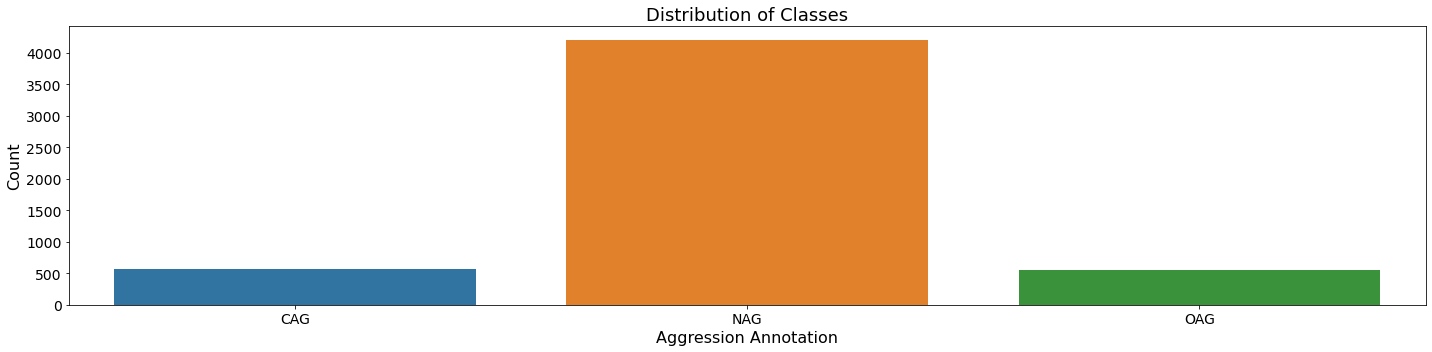

In [8]:
taskA_df = (eng.set_index(['ID', 'Sub-task A']).count(level='Sub-task A'))

barplot(df = taskA_df,
        x = taskA_df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Aggression Annotation",
        ylabel = "Count",
        dim = (20, 5))

eng_train['Sub-task A'].value_counts()

NGEN    3954
GEN      309
Name: Sub-task B, dtype: int64

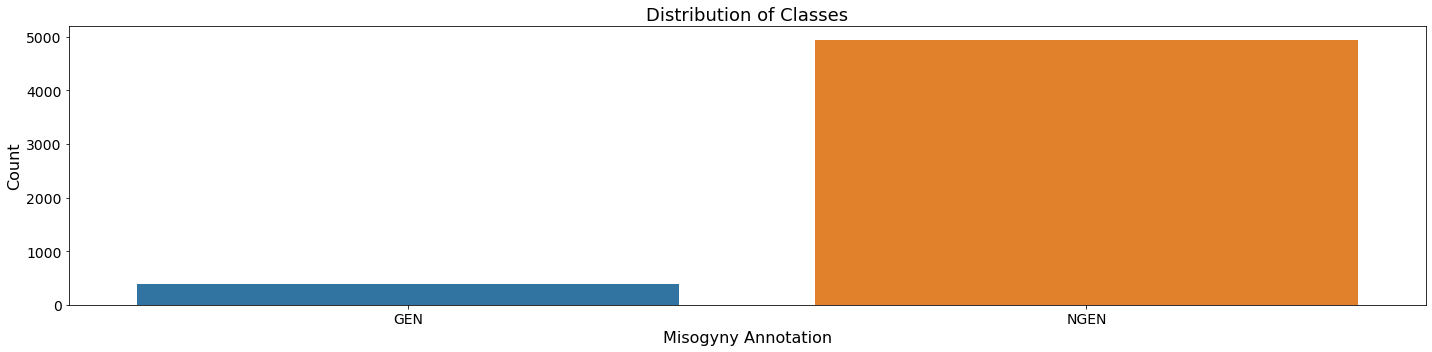

In [9]:
taskB_df = (eng.set_index(['ID', 'Sub-task B']).count(level='Sub-task B'))

barplot(df = taskB_df,
        x = taskB_df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Misogyny Annotation",
        ylabel = "Count",
        dim = (20, 5))

eng_train['Sub-task B'].value_counts()

## DATA CLEANING & NORMALIZATION

### Part-of-Speech Distribution

In [10]:
def POS(df, attribute):
    total_tokens = []
    freq = {}
    for text in df[attribute]:
        doc = nlp(text)
        tokens = []
        for word in doc:
            pos = word.pos_
            if (pos in freq): 
                freq[pos] += 1
            else: 
                freq[pos] = 1
            tokens.append(pos)

        total_tokens.append(tokens)
    pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})
    return pos_df

      POS  Frequency
0     ADJ       7350
1    NOUN      18875
2       X        957
3   SPACE       5286
4   PROPN      10954
5   PUNCT      10837
6    VERB      12425
7    PRON       8000
8     ADP       7137
9   SCONJ       1954
10    DET       9055
11    AUX       6297
12  CCONJ       3037
13   PART       2852
14    ADV       5420
15   INTJ        921
16    NUM       1025
17    SYM        309

Part-of-speech tagging counts for combined corpus


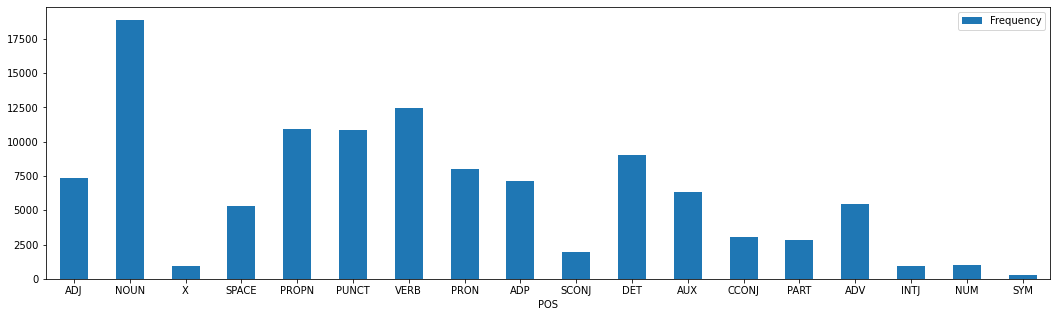

In [11]:
pos_df = POS(eng, 'Text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### List of transliterated proper nouns (PROPN) in the corpus

In [12]:
def transliteration_list(df):
    propn = []
    for text in df['Text']:
        doc = nlp(text)
        for word in doc:
            pos = word.pos_
            if (pos == 'PROPN'): 
                propn.append(word.text)
            else: 
                continue
    return propn

In [13]:
propn = transliteration_list(eng)

### Stopwords

In [14]:
def fetch_stopwords(url):
    stop = pd.read_csv(url, sep='\n', header=0, names=['words'])
    stop = stop['words'].values.tolist()
    return stop

In [17]:
# from stopwordsiso import stopwords
# bangla_stopwords = stopwords('bn')

hinglish_stopwords = fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hinglish')
english_stopwords = set(stopwords.words('english') + hinglish_stopwords)
hindi_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hindi'))
bangla_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/rachitsaksena/Multilingual-Agression-Classification/master/Cache/Models/bangla%20stop.txt'))

In [18]:
stop_dict = {'en': english_stopwords,
             'hi': hindi_stopwords,
             'bn': bangla_stopwords}

### Emoji and Special Character Removal

In [19]:
def deEmojify(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F923"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [20]:
def clean_text(df, lang):
    stop_words = stop_dict[lang]
    df['clean text'] = df['Text']
    for i in range(df.shape[0]):
        sentence = df['Text'].iloc[i]
        sentence = deEmojify(sentence)
        sentence = re.sub(r"([.!?])", r"", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r'', str(sentence))
#         sentence = re.sub(r"[^a-z]+", r" ", sentence)
        sentence = ' '.join(word.lower() for word in sentence.split() if word not in stop_words and len(word)>2)
        df['clean text'].iloc[i] = sentence
#     df['tokenized'] = [tokenizer.tokenize(text) for text in df['clean text']] #problem
    df['tokenized'] = [text.split() for text in df['clean text']]
    return df

In [21]:
clean_text(eng, 'en')
eng.head()

,ID,Text,Sub-task A,Sub-task B,clean text,tokenized
0,C45.451,Next part,NAG,NGEN,next part,"[next, part]"
1,C47.11,Iii8mllllllm\nMdxfvb8o90lplppi0005,NAG,NGEN,iii8mllllllm mdxfvb8o90lplppi0005,"[iii8mllllllm, mdxfvb8o90lplppi0005]"
2,C33.79,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,NAG,NGEN,osm vedio upmake vedios,"[osm, vedio, upmake, vedios]"
3,C4.1961,What the fuck was this? I respect shwetabh and...,NAG,NGEN,what fuck respect shwetabh watching videos lon...,"[what, fuck, respect, shwetabh, watching, vide..."
4,C10.153,Concerned authorities should bring arundathi R...,NAG,NGEN,concerned authorities bring arundathi roy type...,"[concerned, authorities, bring, arundathi, roy..."


      POS  Frequency
0     ADJ       5322
1    NOUN      14521
2   PROPN      11641
3     DET        840
4    VERB       7136
5    PRON        942
6    INTJ        354
7   CCONJ        320
8     ADV       1658
9    PART        433
10    NUM        431
11  PUNCT        774
12    AUX        458
13  SCONJ        123
14    ADP        198
15      X        204
16    SYM        143

Part-of-speech tagging counts for combined corpus


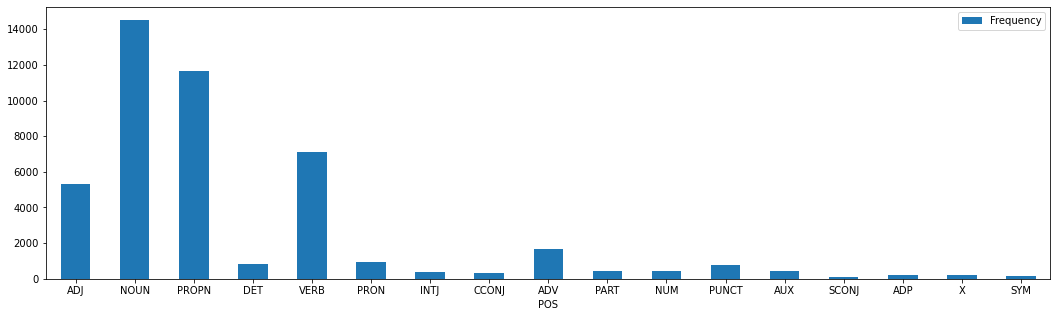

In [22]:
pos_df = POS(eng, 'clean text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### Lexicon Normalization

In [23]:
def script_tag(text):
    ben = re.compile("[" u"\U00000980-\U000009FF" "]+", flags=re.UNICODE) # Bengali
    hin = re.compile("[" u"\U00000900-\U0000097F" "]+", flags=re.UNICODE) # Hindi

    if ben.match(text):
        return 'bn'
    elif hin.match(text):
        return 'hi'
    else:
        return 'en'

In [24]:
def language_tag(df, dest="en"):
    df['normalized lexicon'] = df['clean text']
    ben = re.compile("[" u"\U00000980-\U000009FF" "]+", flags=re.UNICODE) # Bengali
    hin = re.compile("[" u"\U00000900-\U0000097F" "]+", flags=re.UNICODE) # Hindi
    for i in range(df.shape[0]):
        lis = []
        words = df['tokenized'].iloc[i]
        trans_script = translator.translate(" ".join(words)).src
        for word in words:
            script = script_tag(word)
#             print(word, trans_script)
            if(script == 'hi' or trans_script == 'hi'):
                t_word = translator.translate(word, src='hi', dest=dest).text.lower()
                if(script_tag(t_word)==dest): lis.append(t_word)
            elif(script == 'bn' or trans_script == 'bn'):
                t_word = translator.translate(word, src='bn', dest=dest).text.lower()
                if(script_tag(t_word)==dest): lis.append(t_word)
#                 print(word, t_word, lis)
            elif(script == 'en' or trans_script == 'en'):
                if word in propn: #PROPN
                    lis.append(word.lower())
                    continue
                elif len(spellcheck.unknown([word]))!=0: #SPELL CHECK
                    t_word = spellcheck.correction(word).lower()
                else:
                    t_word = word.lower()
                t_word = translator.translate(word, src='en', dest=dest).text.lower()
                if(script_tag(t_word)==dest): lis.append(t_word)
        df['normalized lexicon'].iloc[i] = lis
    return df

In [38]:
# ENGLISH
# language_tag(eng)  # Takes considerable amount of time to run

In [29]:
eng['monolingual'] = eng['normalized lexicon'].apply(lambda x : " ".join(x))

In [301]:
# eng.to_csv('Data/cleaned english.csv', index=False)

In [5]:
eng = pd.read_csv('Data/cleaned english.csv')

In [6]:
eng.sample(5)

,ID,Text,Sub-task A,Sub-task B,clean text,tokenized,normalized lexicon,monolingual
1745,C9.100,Sardard is the biggest name-caller and is now ...,OAG,NGEN,sardard biggest name-caller pontificating name...,"['sardard', 'biggest', 'name-caller', 'pontifi...","['sardard', 'biggest', 'name-caller', 'pontifi...",sardard biggest name-caller pontificating name...
1482,C4.561.4,Yes..but not possible in real life ..dear😉,NAG,NGEN,yesbut possible real life dear,"['yesbut', 'possible', 'real', 'life', 'dear']","['yesbut', 'possible', 'real', 'life', 'dear']",yesbut possible real dear
5031,C7.1544,As usual great video..,NAG,NGEN,usual great video,"['usual', 'great', 'video']","['usual', 'great', 'video']",usual great video
4881,C4.622,Bro I noticed you extending help in raising fu...,NAG,NGEN,bro noticed extending raising funds poor young...,"['bro', 'noticed', 'extending', 'raising', 'fu...","['bro', 'noticed', 'extending', 'raising', 'fu...",bro noticed extending raising funds poor young...
4317,C4.1082.1,@Robinson Wright according to me the best indi...,NAG,NGEN,robinson wright indian youtube channel awarnes...,"['robinson', 'wright', 'indian', 'youtube', 'c...","['robinson', 'wright', 'indian', 'youtube', 'c...",robinson wright youtube channel awarness 1swet...


### Class Interdependence

In [9]:
# WORD CLOUD
def word_cloud(df):
    for agg in classes:
        words = ''
        stopwords = set(STOPWORDS)

        for val in df[df["Sub-task A"] == agg]['monolingual']: 
            tokens = str(val).split() 
            words += " ".join(tokens)+" "

        wordcloud = WordCloud(width = 800, 
                              height = 800, 
                              background_color ='white', 
                              stopwords = stopwords, 
                              min_font_size = 10).generate(words) 

        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 

        print(agg)
        plt.show() 
        print("\n\n\n")

In [11]:
# MOST FREQUENT STATS

def plot_most_frequent_words(df, agg):
    cnt = 0
    fig = plt.figure(figsize = (24, 20), facecolor = "white")   
    cnt += 1
    ax = fig.add_subplot(2, 2, cnt)

    sns.barplot(x = 0, y = df.index, data = df, palette = "deep")

    plt.title(f"Most Common Words from {agg} class are", size = 20)
    plt.xlabel("Frequency", size = 18)
    plt.ylabel("Word", size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 17)

In [12]:
def N_most_freq_words(df, n):
    sns.set(style = "white", palette = "deep")
    lis = []
    for agg in classes:
        subset = df[df["Sub-task A"] == agg]
        vecs = cvec.fit_transform(subset["monolingual"].values.astype('U'))
        vectorized_df = pd.DataFrame(vecs.toarray(), columns = cvec.get_feature_names())

        # Getting the 20 most frequent words from each
        frequent = pd.DataFrame(vectorized_df.sum().sort_values(ascending = False).head(n))
        lis.append(frequent)
        plot_most_frequent_words(df = frequent, agg = agg)
    return lis

In [92]:
def intersection(list1, list2):
    return [word for word in list1 if word in list2]

In [268]:
# REMOVING UTIL
def remove_common_frequent(df, common):
    sentences = []
    for i in range(len(df)):
        sent = ' '.join(token for token in str(df['monolingual'].iloc[i]).split() if token not in common)
        sentences.append(sent)
    df['monolingual'] = sentences

#### 1. English

NAG


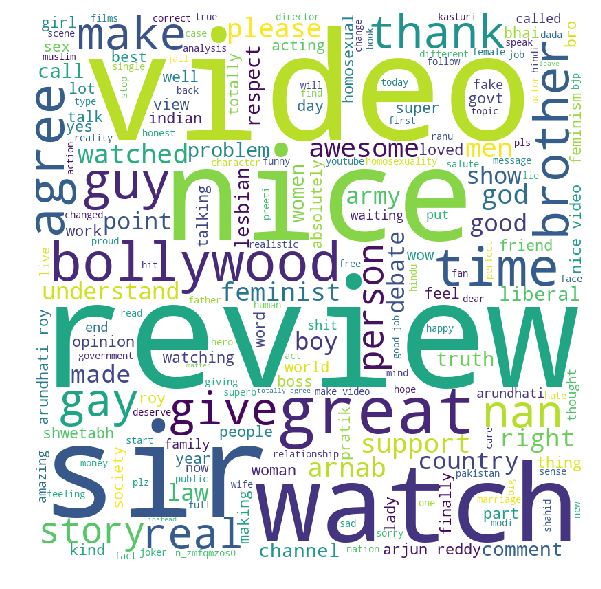





CAG


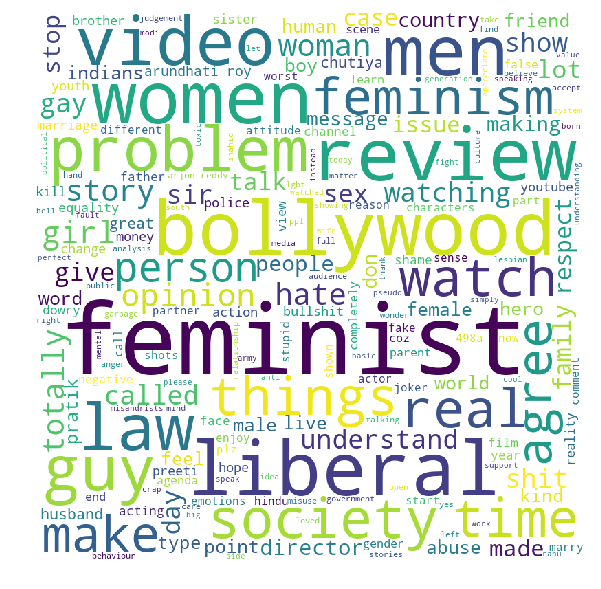





OAG


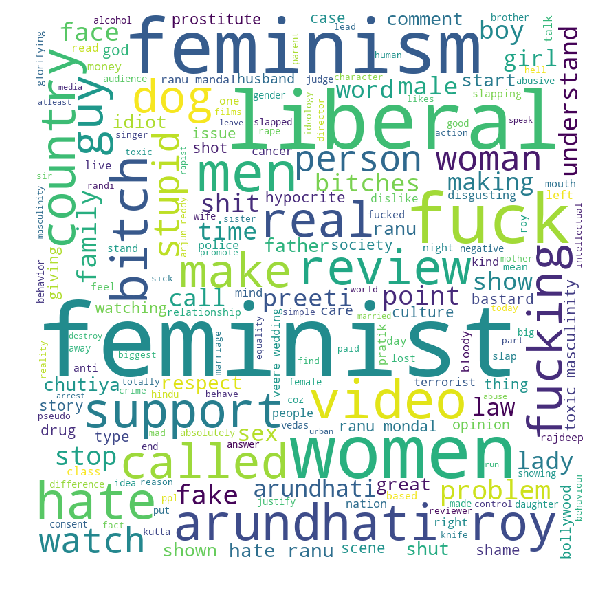

In [160]:
word_cloud(eng)

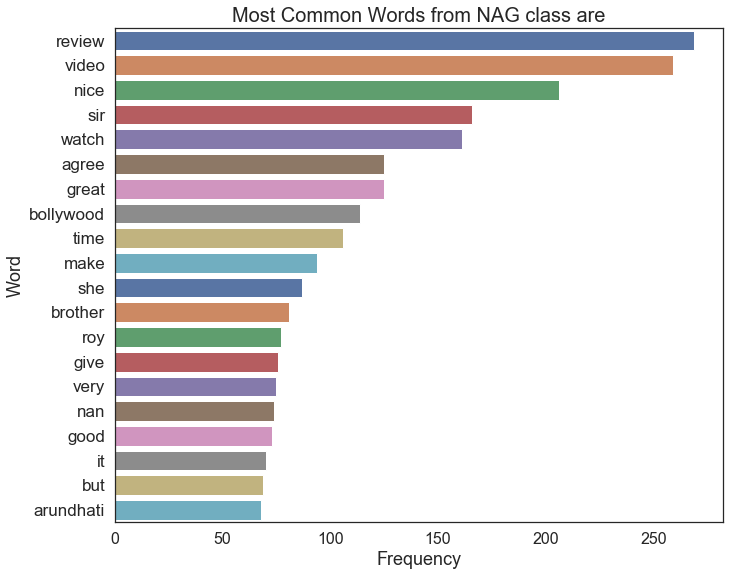

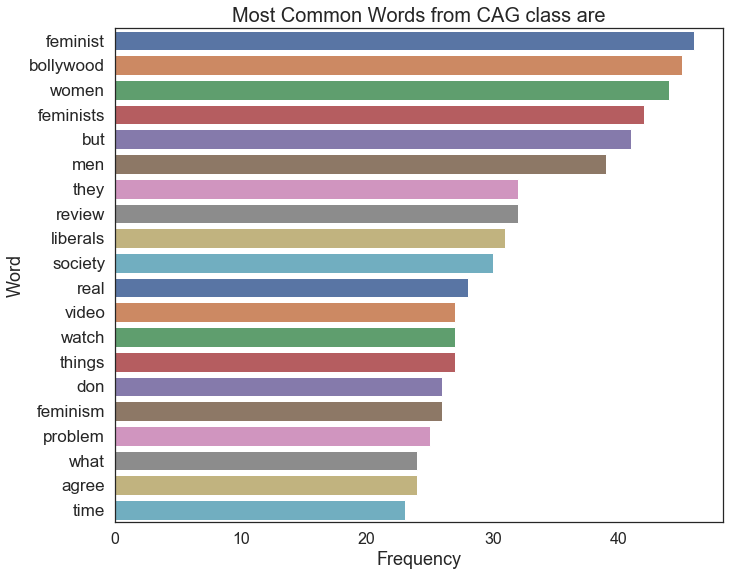

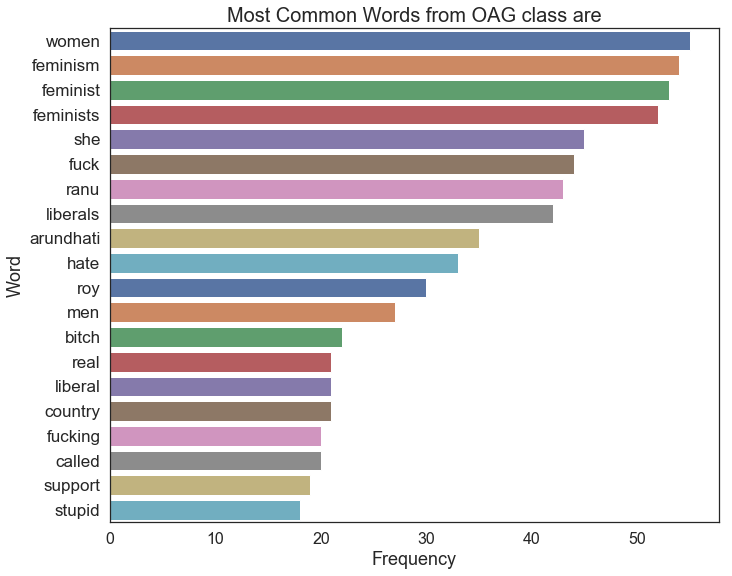

In [161]:
eng_frequent = N_most_freq_words(eng, 20)

In [129]:
common_eng = ['kabir', 'singh', 'movie', 'movies', 'love', 'the', 'india', 'indian']

In [162]:
eng_freq_dict = {}
for i in range(3):
    eng_freq_dict[classes[i]] = list(eng_frequent[i].index)

In [163]:
intersection(intersection(eng_freq_dict['OAG'], eng_freq_dict['CAG']), eng_freq_dict['NAG'])

[]

In [157]:
common_eng.extend(intersection(intersection(eng_freq_dict['OAG'], eng_freq_dict['CAG']), eng_freq_dict['NAG']))

In [158]:
remove_common_frequent(eng, common_eng)

In [164]:
eng.isnull().sum()

ID                     0
Text                   0
Sub-task A             0
Sub-task B             0
clean text            71
tokenized              0
normalized lexicon     0
monolingual            0
dtype: int64

#### 2. Hindi

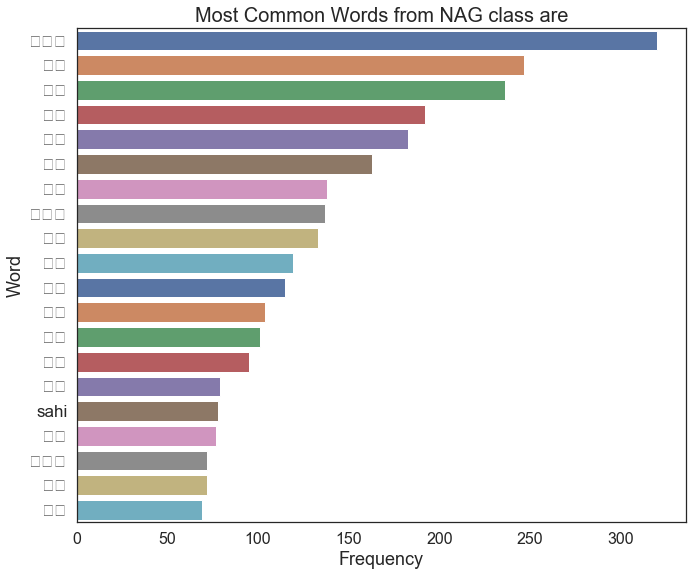

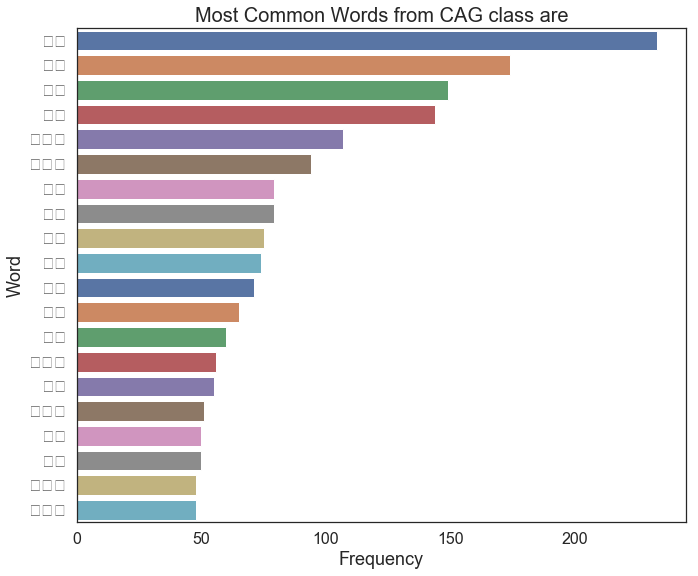

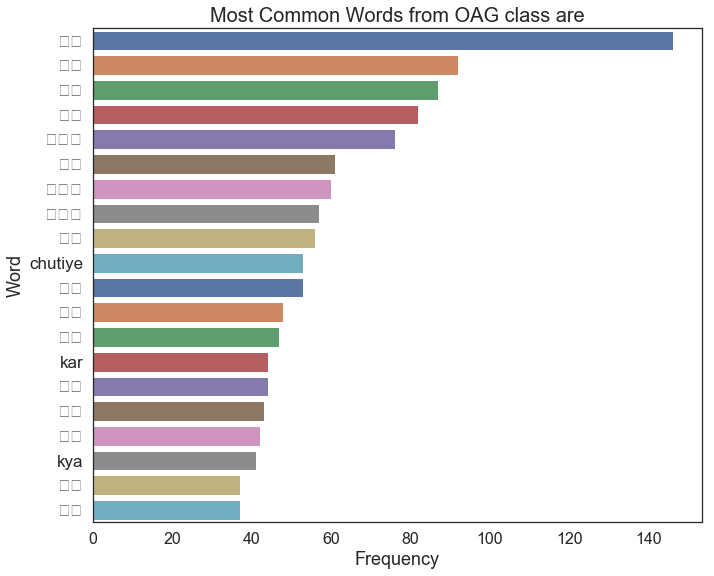

In [257]:
hin_frequent = N_most_freq_words(hin, 20)

In [258]:
for i in range(3):
    print('\n\n')
    print(classes[i])
    print(hin_frequent[i])




NAG
        0
चलच   320
पत    247
सम    236
सह    192
रत    183
कर    163
मह    138
आपक   137
अच    133
बड    119
कह    115
दय    104
बन    101
पर     95
खन     79
sahi   78
हम     77
लड़क    72
लग     72
रह     69



CAG
       0
पत   233
रत   174
कर   149
सम   144
चलच  107
लड़क   94
बन    79
कह    79
हम    75
सह    74
मह    71
रह    65
अच    60
इसल   56
अन    55
गलत   51
इस    50
पर    50
आपक   48
समल   48



OAG
           0
पत       146
कर        92
सम        87
रत        82
चलच       76
पर        61
लड़क       60
समल       57
बन        56
chutiye   53
कह        53
रह        48
सह        47
kar       44
हम        44
बड        43
लत        42
kya       41
कल        37
बत        37


In [59]:
common_hin = ['hai', 'bhi', 'movie', 'bhai', 'aur', 'nahi', 'review', 'पत', 'सह', 'रह', 'कर', 'कह', 'पर', 'अगर', 'चलच', 'सम', 'हम']
for item in common_hin:
    item.encode('utf-8')

In [253]:
hin_freq_dict = {}
for i in range(3):
    hin_freq_dict[classes[i]] = list(hin_frequent[i].index)

In [254]:
intersection(intersection(hin_freq_dict['OAG'], hin_freq_dict['CAG']), hin_freq_dict['NAG'])

['पत', 'कर', 'सम', 'रत', 'चलच', 'पर', 'लड़क', 'बन', 'कह', 'रह', 'सह', 'हम']

In [255]:
common_hin.extend(intersection(intersection(hin_freq_dict['OAG'], hin_freq_dict['CAG']), hin_freq_dict['NAG']))

In [256]:
remove_common_frequent(hin, common_hin)

In [166]:
hin.isnull().sum()

ID                    0
Text                  0
Sub-task A            0
Sub-task B            0
normalized lexicon    0
monolingual           9
dtype: int64

#### 3. Bangla

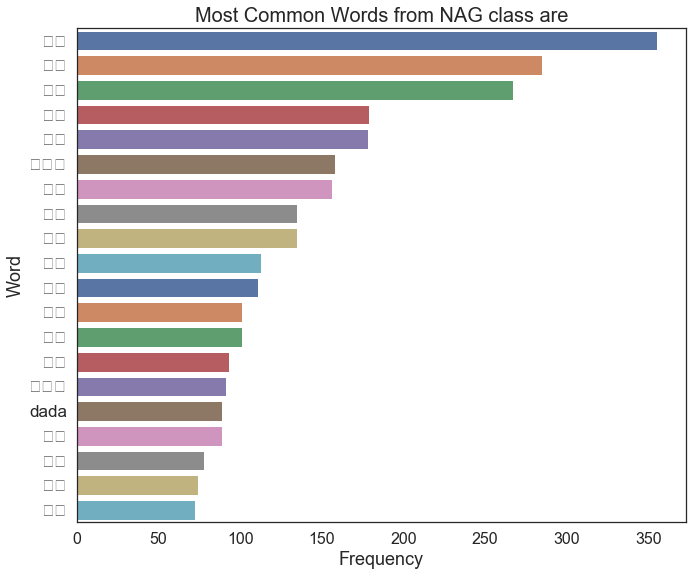

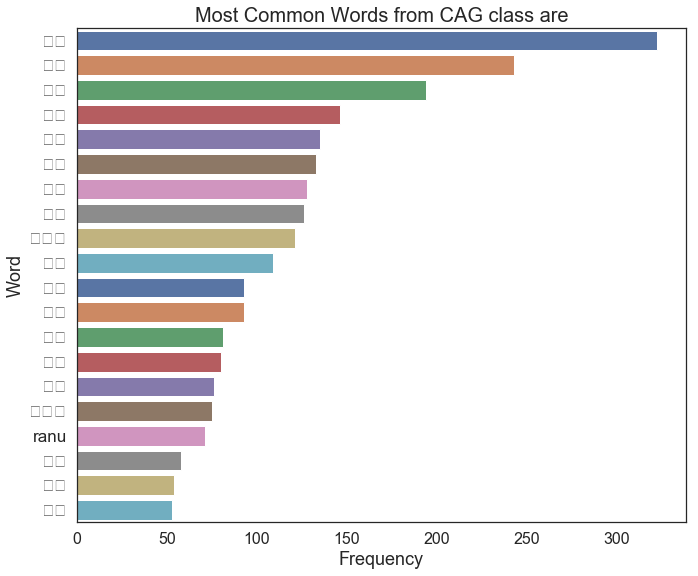

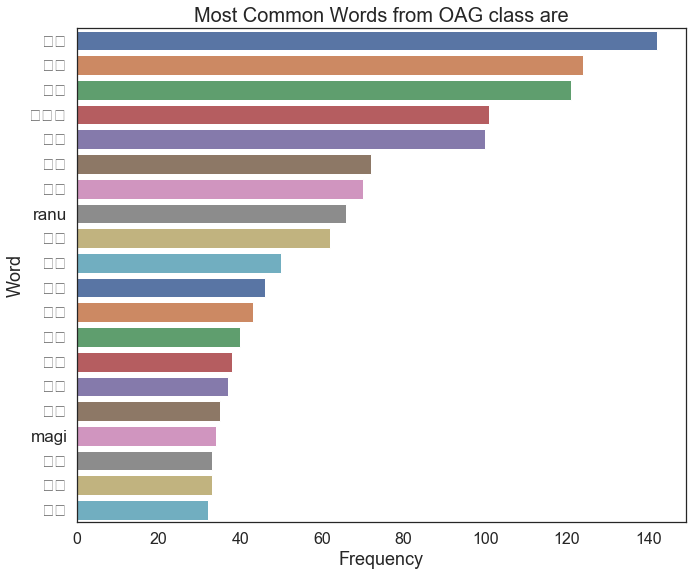

In [277]:
ben_frequent = N_most_freq_words(ben, 20)

In [278]:
for i in range(3):
    print('\n\n')
    print(classes[i])
    print(ben_frequent[i])




NAG
        0
কর    355
আম    285
বল    267
মন    179
কথ    178
আপন   158
পর    156
হয    135
রত    135
অন    113
গল    111
আছ    101
হয়    101
জন     93
একট    91
dada   89
এট     89
এব     78
ডল     74
সম     72



CAG
        0
কর    322
মন    243
আম    194
বল    146
হয়    135
রত    133
ডল    128
হয    126
আপন   121
গল    109
কথ     93
জন     93
অন     81
পর     80
হল     76
একট    75
ranu   71
আছ     58
মত     54
আব     53



OAG
        0
কর    142
মন    124
নক    121
একট   101
ডল    100
রত     72
আম     70
ranu   66
বল     62
উচ     50
হয     46
গল     43
ঘর     40
মহ     38
হব     37
হল     35
magi   34
মত     33
ইম     33
কথ     32


In [279]:
bn_freq_dict = {}
for i in range(3):
    bn_freq_dict[classes[i]] = list(ben_frequent[i].index)

In [280]:
common_bn = intersection(intersection(bn_freq_dict['OAG'], bn_freq_dict['CAG']), bn_freq_dict['NAG'])

In [281]:
common_bn

['কর', 'মন', 'একট', 'ডল', 'রত', 'আম', 'বল', 'হয', 'গল', 'কথ']

In [276]:
remove_common_frequent(ben, common_bn)

## OVERSAMPLING

In [12]:
# label_encoder = preprocessing.LabelEncoder()

# # Using misogyny as a feature
# eng['Sub-task B'] = label_encoder.fit_transform(eng['Sub-task B'])
# hin['Sub-task B'] = label_encoder.fit_transform(hin['Sub-task B'])
# ben['Sub-task B'] = label_encoder.fit_transform(ben['Sub-task B'])

In [13]:
# ENGLISH
# x = eng['monolingual'].apply(lambda w : str(w)) 
# y = eng['Sub-task A']            

# HINDI
# x = hin['monolingual'].apply(lambda w : str(w)) 
# y = hin['Sub-task A']                           

# BANGLA
# x = ben['monolingual'].apply(lambda w : str(w)) 
# y = ben['Sub-task A']                           

In [7]:
x = pd.read_csv('Data/x_eng_oversampled.csv')
y = pd.read_csv('Data/y_eng_oversampled.csv', header=None)

In [8]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')

In [9]:
# # x = eng.loc[:, ['monolingual', 'Sub-task B']]
# x = pd.DataFrame({'monolingual':eng['monolingual'], 'Sub-task B':eng['Sub-task B']})
# x['monolingual'] = x['monolingual'].apply(lambda w : str(w))
# y = eng['Sub-task A']

In [15]:
# x, y = oversample.fit_resample(x, y)

In [8]:
x.shape, y.shape

((12633, 2), (12633, 1))

In [35]:
# x.to_csv('Data/x_eng_oversampled.csv', index=False)
# y.to_csv('Data/y_eng_oversampled.csv', index=False)

In [9]:
B = x['Sub-task B']
x = x.drop(['Sub-task B'], axis=1)
x = x['monolingual'].apply(lambda w : str(w))
y = pd.Series(y.values.flatten())

In [10]:
Counter(y)

Counter({'NAG': 4211, 'CAG': 4211, 'OAG': 4211})

# FEATURE GENERATION & ENGINEERING

In [54]:
def run_tsne(df, y, vec_columns_count):
    temp = pd.DataFrame()
    temp['Sub-task A'] = y
    concat_df = pd.concat([df, temp.reset_index(drop=True)], axis = 1)
    time_start = time.time()
    algo = TSNE(n_components = 2, random_state = 0, n_iter = 2000)
    tsne_data = algo.fit_transform(concat_df.iloc[:,:vec_columns_count])
    time_end = time.time()
    print('t-SNE Completed. Total time it took: {} seconds'.format(time_end-time_start))
    
    # t-SNE plot
    tsne_data = np.vstack((tsne_data.T, concat_df['Sub-task A'])).T
    tsne_df = pd.DataFrame(data = tsne_data , columns=("Dim1", "Dim2", "label"))
    sns.FacetGrid(data = tsne_df, hue = 'label', size = 15).map(plt.scatter, "Dim1", "Dim2").add_legend()
    plt.show()

## Bag Of Words

In [52]:
def bow(x, B, lang):
    cv = CountVectorizer(ngram_range=(1, 2), min_df=0.015) # adjust min_df and max_df from count vectorizer documentation, scikit-learn
    vecs = cv.fit_transform(x)
    bow_df = pd.DataFrame(vecs.toarray(), columns = cv.get_feature_names())
    bow_df['Sub-task B'] = B
    joblib.dump(cv, 'bow_{}.pkl'.format(lang)) # pickled vecs

    print("BoW shape: ", bow_df.shape)

    return bow_df

In [53]:
bow_df = bow(x, B, 'en')
# bow_df = bow(hin, 'hi')
# bow_df = bow(ben, 'bn')

BoW shape:  (12633, 65)


In [54]:
bow_df.sample(5)

,agree,arundhati,arundhati roy,bitch,bollywood,brother,but,called,country,don,...,toxic,understand,video,watch,watching,what,why,woman,women,Sub-task B
3778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
bow_df = pd.read_csv('./Cache/Embeddings/bow.csv')

t-SNE Completed. Total time it took: 283.05461597442627 seconds


/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


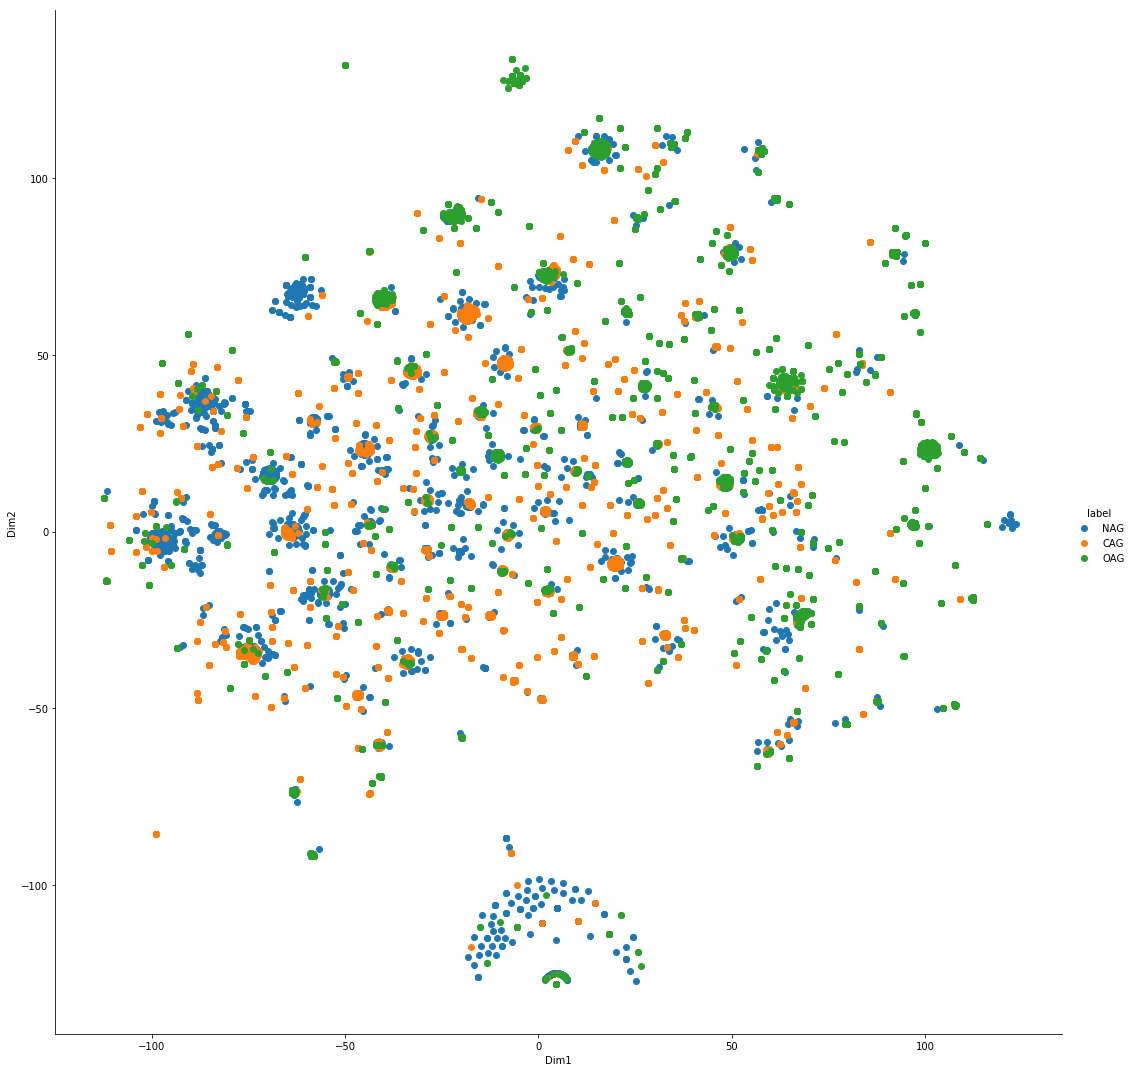

In [72]:
run_tsne(bow_df, y, bow_df.shape[1])

In [43]:
bow_df.to_csv('./Cache/Embeddings/bow.csv', index=False)

## TF-IDF

In [38]:
def tf_idf(x, B, lang):
    tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=.015) # refer to scikit-learn, tfidf vectorizer documentation to tune min_df and max_df 
    vecs = tfidf.fit_transform(x)
    tfidf_df = pd.DataFrame(vecs.toarray(), columns = tfidf.get_feature_names())
#     tfidf_df['Sub-task B'] = B
    joblib.dump(tfidf, 'tfidf_{}.pkl'.format(lang)) # pickled vecs

    print("TF-IDF shape: ", tfidf_df.shape)

    return tfidf_df

In [39]:
tfidf_df = tf_idf(x, y, 'en')
# tfidf_df = tf_idf(hin, 'hi')
# tfidf_df = tf_idf(ben, 'bn')

TF-IDF shape:  (12633, 64)


In [41]:
tfidf_df.sample(5)

,agree,arundhati,arundhati roy,bitch,bollywood,brother,but,called,country,don,...,totally,toxic,understand,video,watch,watching,what,why,woman,women
339,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
7997,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.672656,0.739955,0.0,0.0,0.0,0.0
10562,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
12120,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
7574,0.0,0.0,0.0,0.0,0.426476,0.0,0.427819,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


t-SNE Completed. Total time it took: 256.9576358795166 seconds


/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


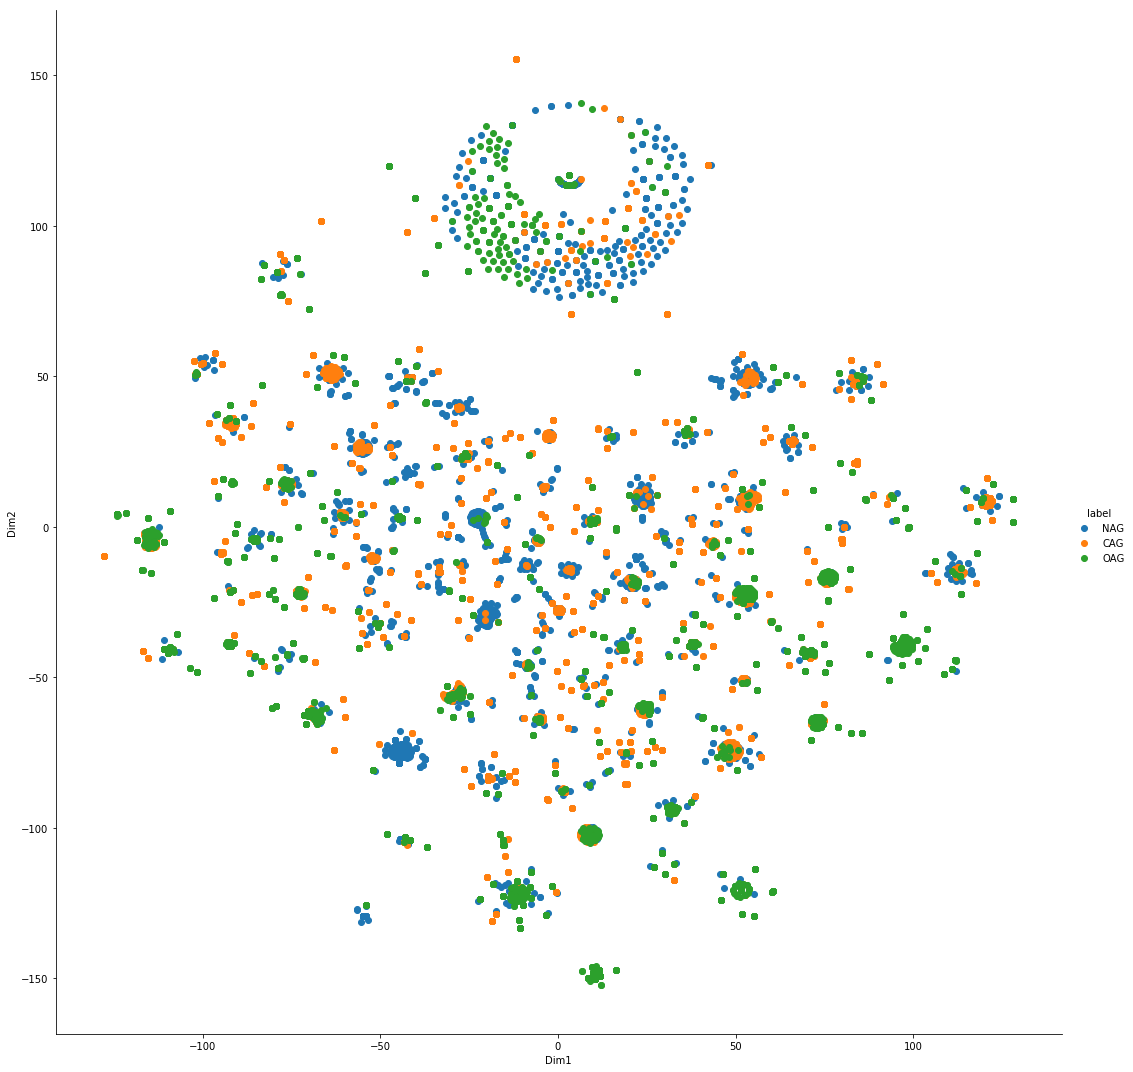

In [74]:
run_tsne(tfidf_df, y, tfidf_df.shape[1])

In [42]:
tfidf_df.to_csv('./Cache/Embeddings/tfidf.csv', index=False)

## Topic Modelled Vectors

### Building the optimal LDA Topic Model

In [64]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # OPTIONAL
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    words = list(sent_to_words(df))
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [65]:
original_texts_df = eng['monolingual'].apply(lambda w : str(w))
corpus, id2word, bigrams = get_corpus(original_texts_df)

In [20]:
mallet_path = '~/Desktop/Development/TRAC-2/Multilingual-Agression-Classification/Cache/Models/mallet-2.0.8/bin/mallet'

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    
    """
    mallet_coherence_values = []
    mallet_list = []
    
    gensim_coherence_values = []
    gensim_list = []
    
    for num_topics in range(start, limit, step):
        
        lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                      corpus=corpus, 
                                                      num_topics=num_topics, 
                                                      id2word=id2word)
        mallet_list.append(lda_mallet)
        mallet_coherencemodel = CoherenceModel(model=lda_mallet, texts=texts, dictionary=dictionary, coherence='c_v')
        mallet_coherence_values.append(mallet_coherencemodel.get_coherence())
        
        lda_gensim = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                      num_topics = num_topics,
                                                      id2word = id2word,
                                                      chunksize = 100,
                                                      workers = 7, # Num. Processing Cores - 1
                                                      passes = 50,
                                                      eval_every = 1,
                                                      per_word_topics=True)
        gensim_list.append(lda_gensim)
        gensim_coherencemodel = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
        gensim_coherence_values.append(gensim_coherencemodel.get_coherence())

    return mallet_list, mallet_coherence_values, gensim_list, gensim_coherence_values

In [25]:
# Can take a long time to run.
mallet_list, mallet_coherence_values, gensim_list, gensim_coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigrams, start=2, limit=40, step=6)

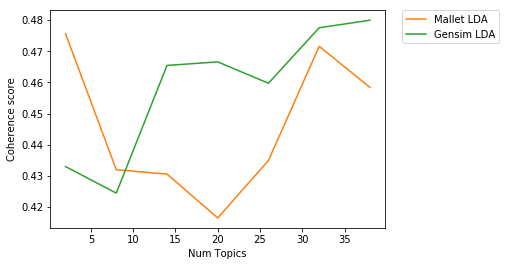

In [26]:
# Show graph
limit=40; start=2; step=6;
x_range = range(start, limit, step)
plt.subplot()
plt.plot(x_range, mallet_coherence_values, 'C1', label='Mallet LDA')
plt.plot(x_range, gensim_coherence_values, 'C2', label='Gensim LDA')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [27]:
# Coherence Scores
for m, cvm, cvg in zip(x_range, mallet_coherence_values, gensim_coherence_values):
    print("For Num Topics =", m, ", Mallet LDA has Coherence Value of", round(cvm, 4), ", Gensim LDA has Coherence Value of", round(cvg, 4))

For Num Topics = 2 , Mallet LDA has Coherence Value of 0.4756 , Gensim LDA has Coherence Value of 0.433
For Num Topics = 8 , Mallet LDA has Coherence Value of 0.432 , Gensim LDA has Coherence Value of 0.4245
For Num Topics = 14 , Mallet LDA has Coherence Value of 0.4306 , Gensim LDA has Coherence Value of 0.4655
For Num Topics = 20 , Mallet LDA has Coherence Value of 0.4165 , Gensim LDA has Coherence Value of 0.4666
For Num Topics = 26 , Mallet LDA has Coherence Value of 0.4349 , Gensim LDA has Coherence Value of 0.4597
For Num Topics = 32 , Mallet LDA has Coherence Value of 0.4716 , Gensim LDA has Coherence Value of 0.4775
For Num Topics = 38 , Mallet LDA has Coherence Value of 0.4584 , Gensim LDA has Coherence Value of 0.48


In [44]:
optimal_model = mallet_list[5] 
optimal_num_topics = 32
optimal_model.save('optimal_lda_model.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(16,
  '0.285*"bollywood" + 0.087*"show" + 0.063*"type" + 0.055*"chutiya" + '
  '0.043*"south" + 0.041*"garbage" + 0.039*"story" + 0.036*"industry" + '
  '0.032*"khan" + 0.029*"reviews"'),
 (6,
  '0.125*"problem" + 0.087*"point" + 0.066*"characters" + 0.055*"hope" + '
  '0.054*"films" + 0.043*"showing" + 0.036*"called" + '
  '0.035*"toxic_masculinity" + 0.035*"issues" + 0.033*"anger"'),
 (29,
  '0.232*"time" + 0.147*"guy" + 0.083*"indians" + 0.061*"absolutely" + '
  '0.059*"bro" + 0.039*"class" + 0.039*"high" + 0.031*"biggest" + '
  '0.029*"watching" + 0.029*"waste"'),
 (9,
  '0.131*"made" + 0.097*"god" + 0.065*"back" + 0.061*"find" + 0.061*"truth" + '
  '0.059*"years" + 0.058*"word" + 0.047*"follow" + 0.043*"learn" + '
  '0.041*"single"'),
 (0,
  '0.207*"feminists" + 0.188*"feminism" + 0.117*"hate" + 0.116*"liberals" + '
  '0.093*"ranu" + 0.046*"equality" + 0.036*"shots" + 0.028*"pseudo" + '
  '0.028*"meaning" + 0.023*"mandal"'),
 (20,
  '0.159*"country" + 0.082*"lady" + 0.068*"stupi

In [40]:
# # Optimal model and the topics
# optimal_model = gensim_list[2] # OBSERVED OPTIMAL MODEL
# optimal_num_topics = 14

# # optimal_model.save('optimal_lda_model.model')

# # Coherence Score: How coherent / well formed the topics are. 
# # Before curve flattening, the higher the better.
# print('\nCoherence Score: ', gensim_coherence_values[2])

# # Preplexity: a measure of how good the model is. The lower the better.
# # Valid for Gensim LDA only; Imlplementation doesn't exist for Mallet LDA.
# print('\nPerplexity Score: ', optimal_model.log_perplexity(corpus))
# print('\nOptimal Topics:')

# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [41]:
# Visualize the topics (ONLY AVAILABLE IN JUPYTER NOTEBOOK)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.090204 -0.080886       1        1  6.326222
13     0.152181  0.084741       2        1  6.066384
3      0.143061  0.039653       3        1  5.778948
15     0.014681 -0.207339       4        1  5.691525
6      0.088246  0.208583       5        1  5.528764
8     -0.026564  0.044414       6        1  5.325455
17    -0.253976 -0.004445       7        1  5.115864
7      0.066660  0.033322       8        1  5.051966
11     0.004327 -0.036189       9        1  5.029432
1      0.101393 -0.049965      10        1  4.946330
5     -0.242713  0.171411      11        1  4.928882
12     0.046096 -0.087701      12        1  4.870208
4     -0.069389  0.245603      13        1  4.794047
9     -0.059361 -0.012365      14        1  4.719134
16     0.016207 -0.157940      15        1  4.710860
18     0.103620  0.094535      16        1  4.582741
14     0.109507 -0.010903      17        1  4.538200
10    -0.186410 -0.121306      18        1  4.468933
19    -0.072839 -0.123091      19        1  3.854855
2     -0.024932 -0.030132      20        1  3.671246, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
159   Default  232.000000         video  232.000000  30.0000  30.0000
16    Default  281.000000        review  281.000000  29.0000  29.0000
83    Default  162.000000           sir  162.000000  28.0000  28.0000
269   Default  145.000000          nice  145.000000  27.0000  27.0000
200   Default  164.000000         women  164.000000  26.0000  26.0000
24    Default  198.000000         watch  198.000000  25.0000  25.0000
65    Default  151.000000     bollywood  151.000000  24.0000  24.0000
123   Default  141.000000         great  141.000000  23.0000  23.0000
47    Default  150.000000           she  150.000000  22.0000  22.0000
356   Default  130.000000         agree  130.000000  21.0000  21.0000
181   Default  133.000000           men  133.000000  20.0000  20.0000
99    Default  137.000000          time  137.000000  19.0000  19.0000
66    Default  112.000000          real  112.000000  18.0000  18.0000
41    Default  124.000000     feminists  124.000000  17.0000  17.0000
161   Default   96.000000       brother   96.000000  16.0000  16.0000
303   Default  134.000000      feminist  134.000000  15.0000  15.0000
51    Default  102.000000           nan  102.000000  14.0000  14.0000
104   Default  106.000000      feminism  106.000000  13.0000  13.0000
70    Default   92.000000        person   92.000000  12.0000  12.0000
298   Default   96.000000      liberals   96.000000  11.0000  11.0000
91    Default   98.000000            it   98.000000  10.0000  10.0000
315   Default   82.000000          hate   82.000000   9.0000   9.0000
43    Default   77.000000           guy   77.000000   8.0000   8.0000
317   Default   76.000000         woman   76.000000   7.0000   7.0000
102   Default   94.000000          that   94.000000   6.0000   6.0000
20    Default   96.000000         story   96.000000   5.0000   5.0000
230   Default   69.000000        please   69.000000   4.0000   4.0000
42    Default  103.000000          give  103.000000   3.0000   3.0000
375   Default   93.000000    understand   93.000000   2.0000   2.0000
286   Default   71.000000          army   71.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
583   Topic20   48.846458        debate   49.774036   3.2858  -2.7642
116   Topic20   42.677006           big   43.604584   3.2831  -2.8992
662   Topic20   30.124790          true   31.052368   3.2743  -3.2476
312   Topic20   29.799974    nice_video   30.727552   3.2740  -3.2584
134   Topic20   27.244507          news   28.172085   3.2712  -3.3481
189   Topic20   22.364798     very_nice   23.292376   3.2640  -3.5454
206   Topic20   22.048328         likes   22.975906   3.2634 

### LDA Vectors

In [7]:
optimal_model =  models.LdaModel.load('./Cache/Models/optimal_lda_model.model')

In [67]:
def lda2vec(optimal_model, optimal_num_topics, x, B, corpus, lang):
    train_vecs = []
    for i in tqdm(range(len(x))):
#         top_topics = optimal_model.get_document_topics(corpus[i], minimum_probability=0.0) # GENSIM
#         topic_vec = [top_topics[i][1] for i in range(optimal_num_topics)]
        topic_vec = optimal_model[corpus[i]]
        topic_vec.extend([len(x.iloc[i])]) # length of text
        topic_vec.extend([len(x.iloc[i].split())]) # word count
        train_vecs.append(topic_vec)
    
    lda_df = pd.DataFrame(train_vecs)
    lda_df['Sub-task B'] = B
    
    fname = 'lda_'+lang+'.csv'
    lda_df.to_csv(fname, index=False)
    
    return lda_df    

In [68]:
lda_df = lda2vec(optimal_model, optimal_num_topics, original_texts_df, eng['Sub-task B'], corpus, lang='en')
# lda_df = lda2vec(optimal_model, optimal_num_topics, x, B, corpus, lang='hi')
# lda_df = lda2vec(optimal_model, optimal_num_topics, x, B, corpus, lang='bn')

In [59]:
lda_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,B
999,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,...,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,20,3,1
620,0.030048,0.040732,0.030048,0.032185,0.030048,0.030048,0.030048,0.030048,0.030048,0.030048,...,0.030048,0.030048,0.030048,0.036458,0.030048,0.042869,0.030048,18,2,1
3833,0.030637,0.030637,0.030637,0.030637,0.030637,0.032816,0.030637,0.030637,0.030637,0.030637,...,0.030637,0.030637,0.030637,0.030637,0.048066,0.030637,0.030637,9,1,1
1289,0.030637,0.030637,0.030637,0.050245,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,...,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,0.030637,21,3,1
3289,0.025615,0.045651,0.042008,0.025615,0.032901,0.025615,0.025615,0.042008,0.038365,0.034722,...,0.025615,0.025615,0.025615,0.025615,0.038365,0.025615,0.067509,187,24,1


t-SNE Completed. Total time it took: 182.78714799880981 seconds


/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


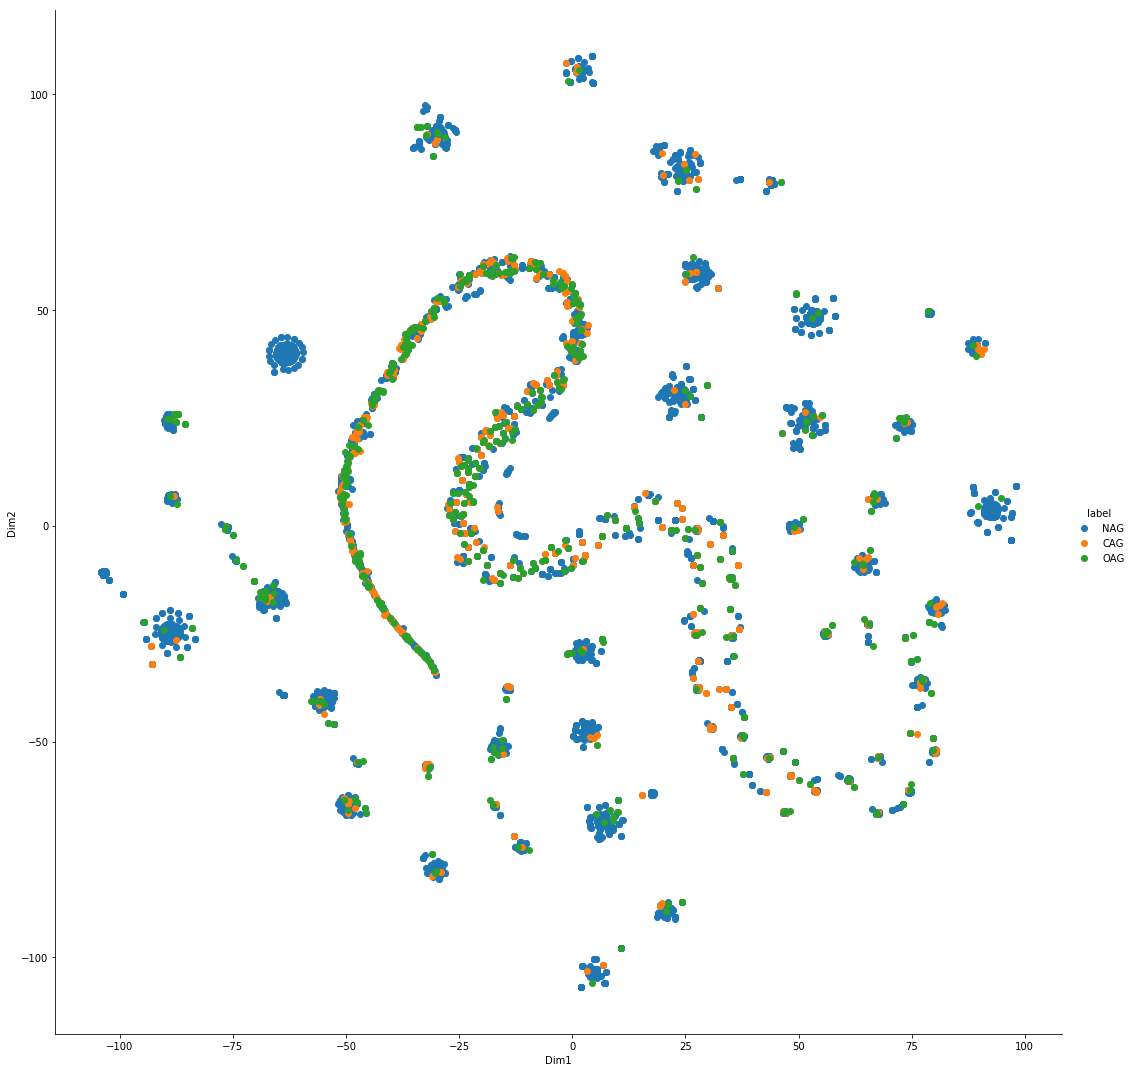

In [57]:
run_tsne(lda_df, y, lda_df.shape[1])

## Generating a Corpus for Skip-Gram Models

In [67]:
def get_corpus(x):
    lines = [str(s).split() for s in x] # Creating a corpus / [list of [lists]]
    return lines

In [49]:
lines = get_corpus(x)

In [68]:
lines = get_corpus(original_texts_df)

## Word2Vec

In [365]:
# phrases = Phrases(sentences=corpus,min_count=25,threshold=50)
# bigram = Phraser(phrases)

In [366]:
# for index,sentence in enumerate(corpus):
#     corpus[index] = bigram[sentence]

In [69]:
# shuffle corpus
def shuffle_corpus(sentences):
    shuffled = list(sentences)
    random.shuffle(shuffled)
    return shuffled

### Average Word2Vec 

In [83]:
# sg - skip gram |  window = size of the window | size = vector dimension
size = 40
window_size = 2 # sentences weren't too long, so
epochs = 10
min_count = 2
workers = 4

In [84]:
def avg_w2v(corpus, B, window_size, size, min_count, workers, epochs, lang):
    # The Word2Vec Model using Gensim
    w2v = Word2Vec(corpus, sg=1, window=window_size, size=size, min_count=min_count, workers=workers, iter=epochs, sample=0.01)
    w2v.build_vocab(sentences=shuffle_corpus(corpus), update=True)
    for i in range(5):
        w2v.train(sentences=shuffle_corpus(corpus), epochs=50, total_examples=w2v.corpus_count)
    w2v.save('w2v.model')

    # Average Word2Vec
    sent_list = []
    k = 0
    for sent in lines:
        avg_w2v = np.empty(50)
        n = 0
        for j in range(len(sent)):
            try:
                avg_w2v += w2v[sent[j]]
                n += 1
            except KeyError:
                continue
        sentence = avg_w2v/(n+np.finfo(float).eps)
        sent_list.append(sentence.tolist())
    w2v_df = pd.DataFrame(sent_list)
    w2v_df['Sub-task B'] = B
    
    fname = 'avg_w2v_'+lang+'.csv'
    w2v_df.to_csv(fname, index=False)
    
    return w2v_df

In [85]:
avg_w2v_df = avg_w2v(lines, eng['Sub-task B'], window_size, size, min_count, workers, epochs, lang='en')
# avg_w2v_df = avg_w2v(lines, B, window_size, size, min_count, workers, epochs, lang='hi')
# avg_w2v_df = avg_w2v(lines, B, window_size, size, min_count, workers, epochs, lang='bn')

ValueError: operands could not be broadcast together with shapes (50,) (40,) (50,) 

In [371]:
# load word2vec model
# w2v = Word2Vec.load('w2v.model')
# w2v eval from https://www.kaggle.com/harmanpreet93/train-word2vec-on-hotel-reviews-dataset

t-SNE Completed. Total time it took: 83.18063187599182 seconds


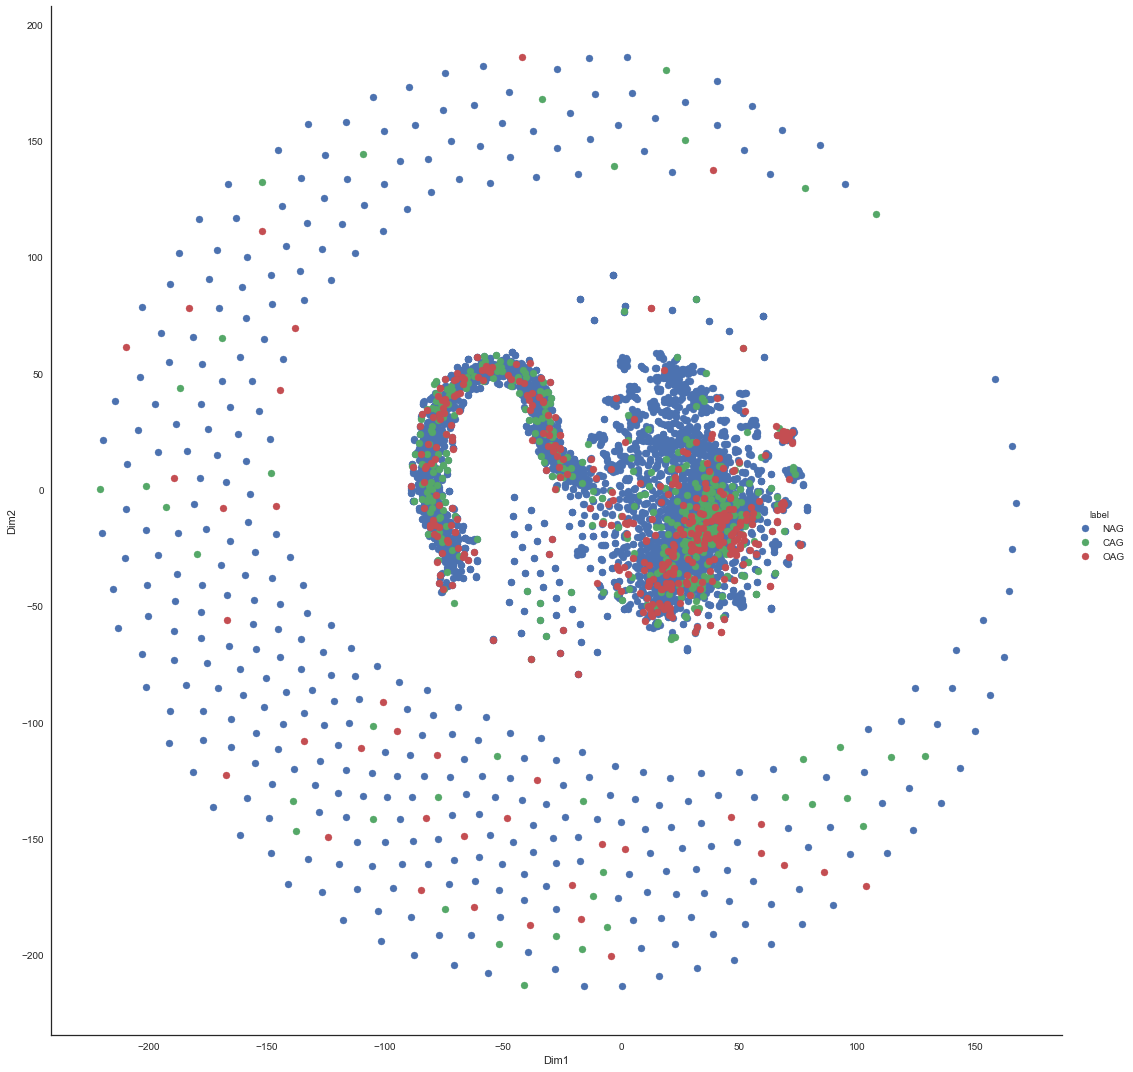

In [375]:
run_tsne(avg_w2v_df, y, avg_w2v_df.shape[1])

### TF-IDF Weighted Word2Vec

In [57]:
def tfidf_w2v(corpus, B, window_size, size, min_count, workers, epochs, lang):
    # The Word2Vec Model using Gensim
    w2v = Word2Vec(corpus, sg=1, window=window_size, size=size, min_count=min_count, workers=workers, iter=epochs, sample=0.01)
    w2v.build_vocab(sentences=shuffle_corpus(corpus), update=True)
    for i in range(5):
        w2v.train(sentences=shuffle_corpus(corpus), epochs=50, total_examples=w2v.corpus_count)
    w2v.save('w2v.model')
    
    # refer to scikit-learn, tfidf vectorizer documentation to tune min_df and max_df 
    tfidf_w2v = TfidfVectorizer(ngram_range=(1, 5), min_df=.01)
    w2v_words = w2v.wv.vocab

    # Weights Dict
#     x = eng_train_clean['monolingual'].apply(lambda w : str(w))
    tfidf_w2vecs = tfidf_w2v.fit_transform(x)
    weights = dict(zip(tfidf_w2v.get_feature_names(), tfidf_w2v.idf_))
    
    tfidf_features = tfidf_w2v.get_feature_names()
    tfidf_sent_vectors = []
    row = 0
    for sent in tqdm(lines):
        sent_vec = np.zeros(100)
        weight_sum = 0
        for word in sent:
            if word in w2v_words and word in tfidf_features:
                vec = w2v.wv[word]
                tf_idf = weights[word]*(sent.count(word)/len(sent))
                sent_vec += (vec*tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec.tolist())
        row += 1
        
    tfidf_w2v_df = pd.DataFrame(tfidf_sent_vectors)
    tfidf_w2v_df['Sub-task B'] = B
    
    fname = 'tfidf_w2v_'+lang+'.csv'
    tfidf_w2v_df.to_csv(fname, index=False)
    
    return tfidf_w2v_df

In [58]:
tfidf_w2v_df = tfidf_w2v(corpus, B, window_size, size, min_count, workers, epochs, lang='en')
# tfidf_w2v_df = tfidf_w2v(corpus, B, window_size, size, min_count, workers, epochs, lang='hi')
# tfidf_w2v_df = tfidf_w2v(corpus, B, window_size, size, min_count, workers, epochs, lang='bn')

100%|██████████| 12633/12633 [00:00<00:00, 13870.86it/s]


t-SNE Completed. Total time it took: 228.01522731781006 seconds


/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


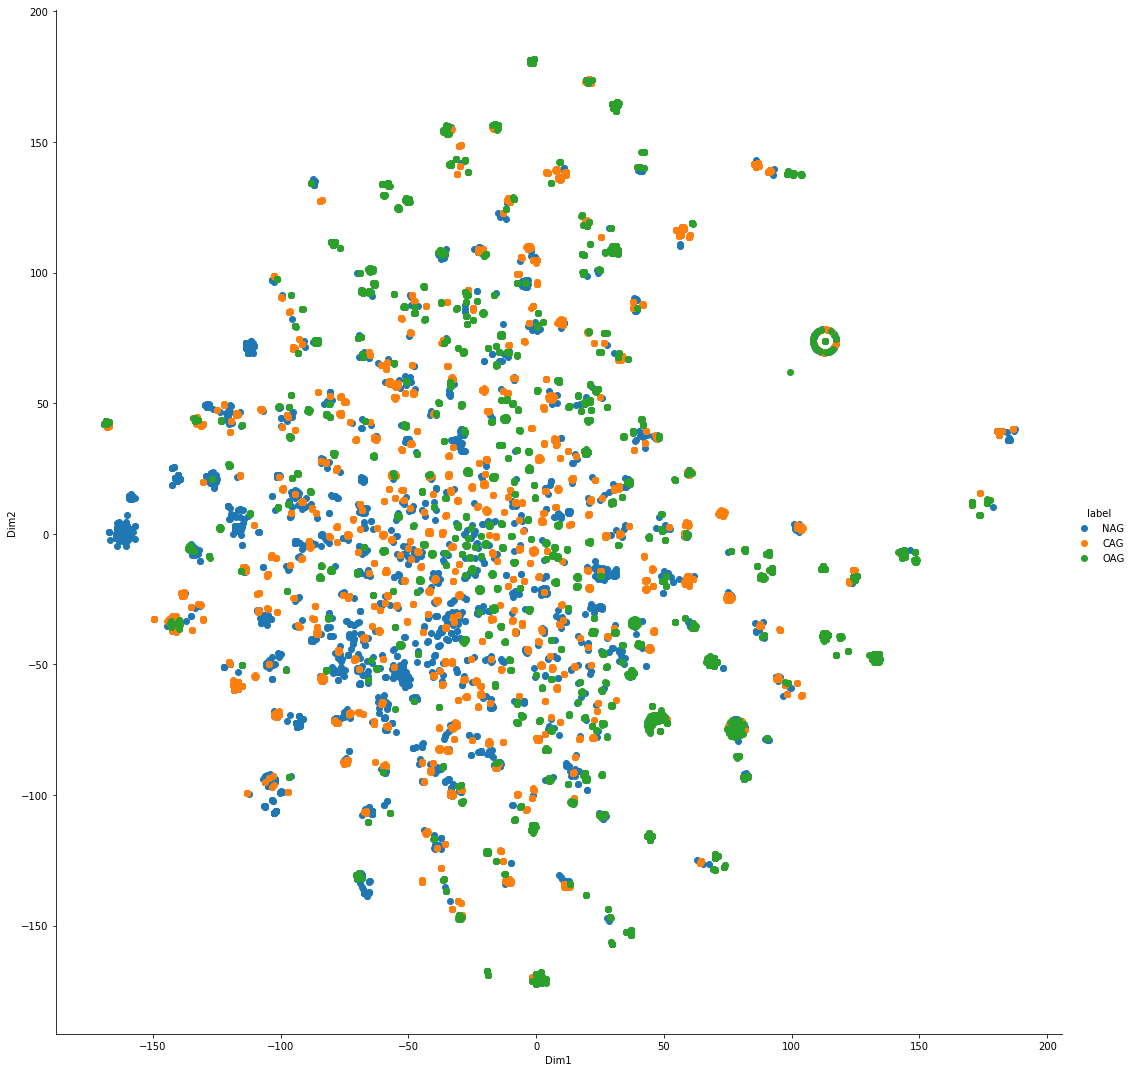

In [71]:
run_tsne(tfidf_w2v_df, y, tfidf_w2v_df.shape[1])

**The normal one looked better than the shuffled corpus tbh**

## GloVe Embeddings

### Corpus Trained GloVe

In [261]:
def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

In [388]:
def co_occurrence_df(corpus):
    # Create one list using many lists
    data = list(itertools.chain.from_iterable(corpus))
    matrix, vocab_index = generate_co_occurrence_matrix(data)
    data_matrix = pd.DataFrame(matrix, index=vocab_index, columns=vocab_index)
    return np.array(data_matrix)

,neglect,tag,class,bacterial,drama,krskte,doubt,rendering,craziness,four,...,tribal,film,word,discovered,view,raise,liking,bad,posting,chill
neglect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
class,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bacterial,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
drama,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
krskte,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doubt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rendering,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
craziness,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
four,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
data_matrix = co_occurrence_df(corpus)
pd.DataFrame(data_matrix)

In [242]:
def glove_embeddings(corpus, lang):
    data_matrix = co_occurrence_df(corpus)
    glove = GloVe(n=300, max_iter=1000) 
    embeddings = glove.fit(data_matrix)
    embeddings = pd.DataFrame(embeddings)
    fname = 'glove_'+lang+'.csv'
    embeddings.to_csv(fname, index=False)
    return embeddings

Iteration 1000: error 0.0027

array([[-0.00307367, -0.029363  ,  0.0374286 , ...,  0.01461433,
        -0.03661498, -0.00838053],
       [-0.00060389, -0.02162649,  0.03546075, ..., -0.03162759,
        -0.0304772 ,  0.01673597],
       [-0.0237541 , -0.01043325, -0.01181269, ..., -0.0088648 ,
         0.01232723,  0.04435216],
       ...,
       [-0.05975632, -0.00463997, -0.02441853, ...,  0.05744439,
         0.00093427,  0.06000691],
       [-0.00209003,  0.01864768, -0.01472435, ...,  0.01589482,
         0.00718688, -0.00182206],
       [-0.00414972, -0.00519305, -0.01051859, ...,  0.00868516,
        -0.02128282,  0.02655739]])

In [ ]:
glove_df = glove_embeddings(corpus, lang='en')
# glove_df = glove_embeddings(corpus, lang='hi')
# glove_df = glove_embeddings(corpus, lang='bn')
glove_df.sample(5)